# Imports

In [31]:
import numpy as np
import pandas as pd

import os

from datetime import timedelta, date
from PIL import ImageColor
from PIL import Image

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


Populating the interactive namespace from numpy and matplotlib


# Changes to cartogram program C Code


Changes to the go_cart program c code that is submitted to open source are in 
https://github.com/Flow-Based-Cartograms/go_cart/commit/2df3c5a9ef45aab5042de8a0407dbdaf988a0dfd
https://github.com/johnyrufus/go_cart/commit/178fb5621c073ee012f7f5cbddc8997b8fb7998a


# Load the necessary datasets

In [32]:
data_population = pd.read_csv('data/us-population.csv', index_col=['state'])
print(data_population.head(3))

data_cases = pd.read_csv('data/us-states.csv', index_col=['date', 'state'])
data_cases['state'] = data_cases.index.get_level_values('state') 
print(data_cases.head(3))

def get_cases_per_million(row):
    cases, state = row['cases'], row['state']
    return (cases/data_population.loc[state].population) * 1000000 if state in data_population.index else cases

def get_deaths_per_million(row):
    deaths, state = row['deaths'], row['state']
    return (deaths/data_population.loc[state].population) * 1000000 if state in data_population.index else deaths

data_cases['cases_per_million'] = data_cases.apply(lambda row: get_cases_per_million(row), axis=1)
data_cases['deaths_per_million'] = data_cases.apply(lambda row: get_deaths_per_million(row), axis=1)

lo, hi = data_cases['deaths_per_million'].min(), data_cases['deaths_per_million'].max()
print(data_cases.head(3), lo, hi)

# https://www.kaggle.com/lucasvictor/us-state-populations-2018/data
# https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv


            population
state                 
California    39776830
Texas         28704330
Florida       21312211
                       fips  cases  deaths       state
date       state                                      
2020-01-21 Washington    53      1       0  Washington
2020-01-22 Washington    53      1       0  Washington
2020-01-23 Washington    53      1       0  Washington
                       fips  cases  deaths       state  cases_per_million  \
date       state                                                            
2020-01-21 Washington    53      1       0  Washington           0.132792   
2020-01-22 Washington    53      1       0  Washington           0.132792   
2020-01-23 Washington    53      1       0  Washington           0.132792   

                       deaths_per_million  
date       state                           
2020-01-21 Washington                 0.0  
2020-01-22 Washington                 0.0  
2020-01-23 Washington                 0.0   0.0 

In [33]:
data_population = pd.read_csv('data/us-population.csv', index_col=['state'])
data_population.head(3)

# https://www.kaggle.com/lucasvictor/us-state-populations-2018/data

,population
state,
California,39776830
Texas,28704330
Florida,21312211


In [34]:
data_maps = pd.read_csv('data/us-contiguous-states.csv', index_col=['state'])
data_maps.head()

,id,data,r,g,b
state,,,,,
Alabama,1,9,0.5,0.5,0.5
Arizona,2,11,0.7,0.1,0.3
Arkansas,3,6,0.5,0.5,0.5
California,4,55,0.5,0.5,0.5
Colorado,5,9,0.5,0.5,0.5


In [35]:
states = data_maps.index.to_list()
print(states)

['Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']


In [36]:
data_color = pd.read_csv('data/us-states-color.csv', index_col=['state'])
data_color.head(3)


,population,votes,color
state,,,
Alabama,4780127,9,#e7298a
Alaska,4780127,9,#d95f02
Arizona,6392307,11,#d95f02


# Prototype images of cartograms not based on Albers usa projection

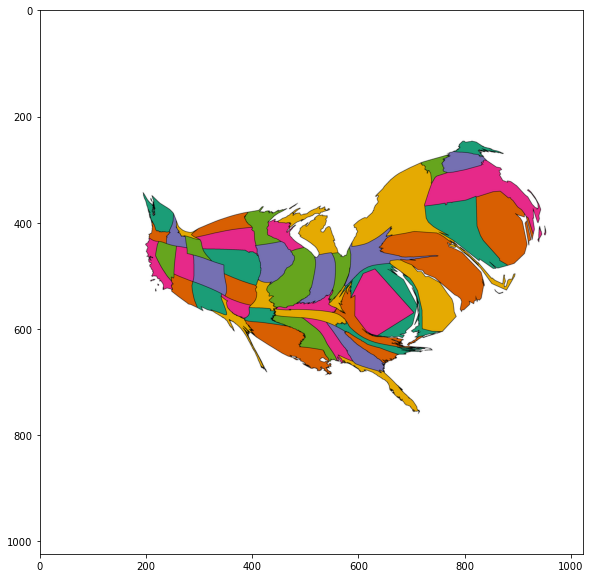

In [37]:
from datetime import timedelta, date

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = date(2020, 5, 21)
end_date = date(2020, 5, 22)
for date in daterange(start_date, end_date):
    date = date.strftime("%Y-%m-%d")
    fname = 'data/csvs/' + date + '.csv'
    fd = open(fname, 'w')
    for state in states:
        line = []
        line.append(int(data_maps.loc[state].id))
        cases = 0.0001
        if (date, state) in data_cases.index:
            cases += data_cases.loc[(date, state)].cases
            
        line.append( (cases/data_population.loc[state].population) * 1000000)
        line.append(state)
        
        if cases == 0.0001:
            line.extend([0.5, 0.5, 0.5])
        else:
            line.extend([ x/256.0 for x in ImageColor.getcolor(data_color.loc[state].color, "RGB")])
        #print(line)
        fd.write(','.join(map(str, line))+'\n')
    fd.close()
    os.system('cartogram -eg data/usa_contiguous_arcgis.json -a ' + fname)
    

    bounds = (1024, 1024)

    pic = Image.open('cartogram.eps')
    pic.load(scale=10)

    if pic.mode in ('P', '1'):
        pic = pic.convert("RGB")

    ratio = min(bounds[0] / pic.size[0],
                bounds[1] / pic.size[1])
    new_size = (int(pic.size[0] * ratio), int(pic.size[1] * ratio))
    pic = pic.resize(new_size, Image.ANTIALIAS)

    pic.save(fname.split('.')[0] + '.png')
    #https://stackoverflow.com/questions/45828514/how-to-convert-an-eps-file-into-a-png-in-python-3-6
            

plt.figure(figsize = (20,10))
plt.imshow(mpimg.imread(fname.split('.')[0] + '.png')) 
plt.show()

In [13]:
# Generate ordered images
os.system(r'''find data/csvs/ -name '*.png' | xargs ls -rt | awk 'BEGIN{ a=0 }{ printf "cp %s data/pngs/%04d.png\n", $0, a++ }' | bash''')

In [14]:
# Generate the time lapse video
import os
os.system(r'''ffmpeg  -y -f image2 -r 2 -i data/pngs/%4d.png -threads 8 -s:v 1920x1080 -vcodec libx264 -preset veryslow -qp 0 -map 0:0  movie2.mkv''')

# Use AlbersUS Projection

In [38]:
data_maps_albers = pd.read_csv('data/albers_composite_us_states_data.csv', index_col=['state'])
data_maps_albers.head()
data_color = pd.read_csv('data/us-states-color.csv', index_col=['state'])
data_color.head()
states = data_maps_albers.index.to_list()
print(states)

['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']


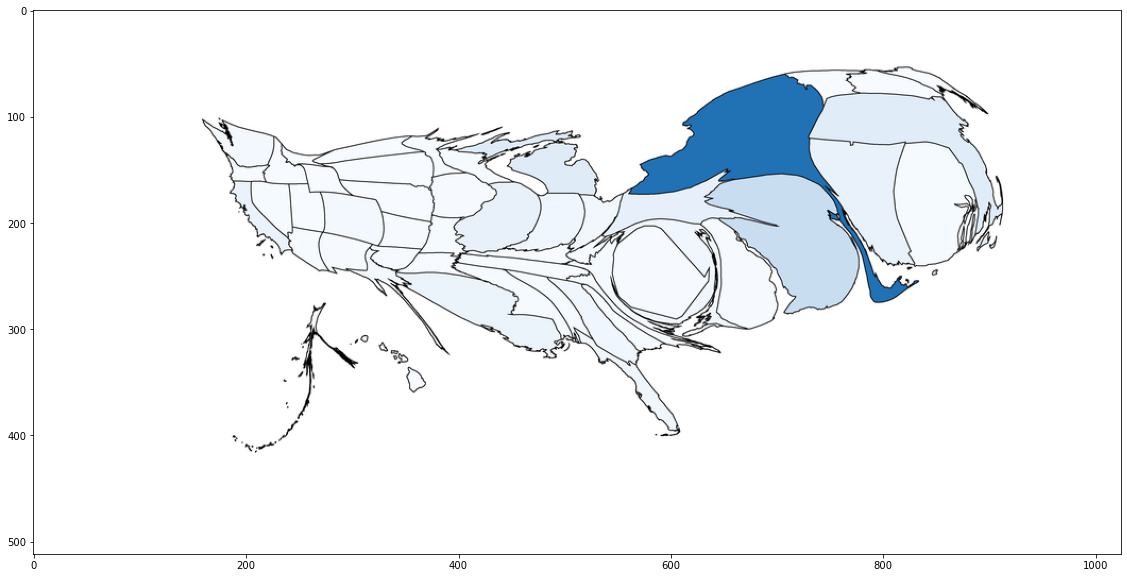

In [39]:
import os

from datetime import timedelta, date
from PIL import ImageColor
from PIL import Image

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import OrderedDict

cmaps = OrderedDict()
cmaps['Sequential'] = [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']


def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)


lo, hi = data_cases['deaths'].min(), data_cases['deaths'].max()

def getColor(x, lo=lo, hi=hi):
    x = (x - lo) / (hi - lo)
    rgb = cm.get_cmap(cmaps['Sequential'][2])([x])[np.newaxis, :, :3]
    return rgb[0][0]

start_date = date(2020, 5, 1)
end_date = date(2020, 5, 2)
for date in daterange(start_date, end_date):
    date = date.strftime("%Y-%m-%d")
    fname = 'data/csvs_albers/' + date + '.csv'
    fd = open(fname, 'w')
    for state in states:
        line = []
        line.append(int(data_maps_albers.loc[state].id))
        cases = 1
        deaths = 0
        if (date, state) in data_cases.index:
            cases += data_cases.loc[(date, state)].cases
            deaths += data_cases.loc[(date, state)].deaths
        line.append( (cases/data_population.loc[state].population) * 1000000)
        line.append(state)
        
        if cases == 0.0001:
            line.extend([0.5, 0.5, 0.5])
        else:
            line.extend(getColor(deaths))
        #print(line)
        fd.write(','.join(map(str, line))+'\n')
    fd.close()
    os.system('cartogram -eg data/albers_composite_us_states_processedmap.json -a ' + fname)
    

    bounds = (1024, 1024)

    # Needs ghostscript installed for this to run
    pic = Image.open('cartogram.eps')
    pic.load(scale=10)

    if pic.mode in ('P', '1'):
        pic = pic.convert("RGB")

    ratio = min(bounds[0] / pic.size[0],
                bounds[1] / pic.size[1])
    new_size = (int(pic.size[0] * ratio), int(pic.size[1] * ratio))
    pic = pic.resize(new_size, Image.ANTIALIAS)

    # Save to PNG
    pic.save(fname.split('.')[0] + '.png')
    #https://stackoverflow.com/questions/45828514/how-to-convert-an-eps-file-into-a-png-in-python-3-6

plt.figure(figsize = (20,10))
plt.imshow(mpimg.imread(fname.split('.')[0] + '.png')) 
plt.show()

In [40]:
data_maps_albers = pd.read_csv('data/albers_composite_us_states_data.csv', index_col=['state'])
data_color = pd.read_csv('data/us-states-color.csv', index_col=['state'])
data_color.head()
states = data_maps_albers.index.to_list()

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

us_abbrev_state = {v: k for k, v in us_state_abbrev.items()}


# Include Recovered cases and normalized per million population

In [41]:
data_cases = pd.read_csv('data/us_states_covid19_daily.csv', index_col=['date', 'state'])
data_cases['state'] = data_cases.index.get_level_values('state') 
fips = pd.read_csv('data/states_fips.csv', index_col=['state_abbr'])

def get_cases_per_million(row):
    cases, state = row['positive'], row['state']
    state = us_abbrev_state[state]
    return (cases/data_population.loc[state].population) * 1000000 if state in data_population.index else cases

def get_current_cases_per_million(row):
    cases, state = row['positive'], row['state']
    state = us_abbrev_state[state]
    cases -= row['recovered']
    return (cases/data_population.loc[state].population) * 1000000 if state in data_population.index else cases


def get_deaths_per_million(row):
    deaths, state = row['death'], row['state']
    state = us_abbrev_state[state]
    return (deaths/data_population.loc[state].population) * 1000000 if state in data_population.index else deaths

def get_population(row):
    state = row['state']
    state = us_abbrev_state[state]
    if state not in data_population.index: return 1
    return data_population.loc[state].population

def get_fips(row):
    return fips.loc[row['state']]['fips'] if row['state'] in fips.index else 99

data_cases['recovered'] = data_cases['recovered'].fillna(0)
data_cases['death'] = data_cases['death'].fillna(0)
data_cases['positive'] = data_cases['positive'].fillna(0)

data_cases['cases_per_million'] = data_cases.apply(lambda row: get_cases_per_million(row), axis=1)
data_cases['deaths_per_million'] = data_cases.apply(lambda row: get_deaths_per_million(row), axis=1)
data_cases['population'] = data_cases.apply(lambda row: get_population(row), axis=1)
data_cases['current_cases_per_million'] = data_cases.apply(lambda row: get_current_cases_per_million(row), axis=1)
data_cases['fips'] = data_cases.apply(lambda row: get_fips(row), axis=1)

data_cases_cleaned = data_cases[['fips','positive','recovered','death','state','population','cases_per_million','current_cases_per_million','deaths_per_million']]

lo, hi = data_cases_cleaned['deaths_per_million'].min(), data_cases_cleaned['deaths_per_million'].max()

In [42]:
data_cases_cleaned.head(10)

fips  positive  recovered   death state  population  \
date     state                                                        
20200720 AK        2    2414.0      712.0    18.0    AK      738068   
         AL        1   68891.0    29736.0  1291.0    AL     4888949   
         AR        5   33927.0    26397.0   357.0    AR     3020327   
         AS       99       0.0        0.0     0.0    AS           1   
         AZ        4  145183.0    18518.0  2784.0    AZ     7123898   
         CA        6  391538.0        0.0  7694.0    CA    39776830   
         CO        8   40142.0     4969.0  1615.0    CO     5684203   
         CT        9   48055.0     8466.0  4406.0    CT     3588683   
         DC       11   11339.0     1909.0   579.0    DC      703608   
         DE       10   13519.0     7362.0   523.0    DE      971180   

                cases_per_million  current_cases_per_million  \
date     state                                                 
20200720 AK           3270.701345                2306.020583   
         AL          14091.167652                8008.878800   
         AR          11232.889684                2493.107534   
         AS              0.000000                   0.000000   
         AZ          20379.713466               17780.293878   
         CA           9843.368614                9843.368614   
         CO           7062.027869                6187.850786   
         CT          13390.706284               11031.623579   
         DC          16115.507498               13402.349035   
         DE          13920.179575                6339.710455   

                deaths_per_million  
date     state                      
20200720 AK              24.387997  
         AL             264.064935  
         AR             118.199122  
         AS               0.000000  
         AZ             390.797285  
         CA             193.429190  
         CO             284.120747  
         CT            1227.748453  
         DC             822.901388  
         DE             538.520151

# Generate Choropleth time series

In [43]:
import altair as alt
from vega_datasets import data
import datetime

days = [20200201, 20200301, 20200401, 20200501, 20200601, 20200701]
days_datasets = [0] * len(days)
for i,day in enumerate(days):
    days_datasets[i] = data_cases_cleaned.loc[(day)].copy()
    for state in states:
        if (us_state_abbrev[state]) not in days_datasets[i].index:
            days_datasets[i].loc[us_state_abbrev[state]] = [fips.loc[us_state_abbrev[state]].fips, 0, 0, 0, us_state_abbrev[state], 0, 0, 0, 0]
charts = [0] * len(days)
states_topo = alt.topo_feature(data.us_10m.url, 'states')

def choropleth(day, ds, column, title):
    chart = alt.Chart(states_topo).mark_geoshape().encode(
        color=alt.Color(column, scale=alt.Scale(scheme='goldorange')),
        tooltip = [column, 'death:Q', 'state:O']
    ).transform_lookup(
        lookup='id',
        from_=alt.LookupData(ds, 'fips', ['positive', 'state', 'death', 'current_cases_per_million', 'deaths_per_million'])
    ).project(
        type='albersUsa'
    ).properties(
        width=330,
        height=250,
        title = title
    )
    return chart
for i, day in enumerate(days):
    charts[i] = choropleth(day, days_datasets[i], 'positive:Q', datetime.datetime.strptime(str(day), '%Y%m%d').strftime('%Y-%m-%d'))


alt.vconcat(alt.hconcat(charts[0], charts[1], charts[2]), alt.hconcat(charts[3], charts[4], charts[5]))

alt.VConcatChart(...)

In [44]:
for i, day in enumerate(days):
    charts[i] = choropleth(day, days_datasets[i], 'current_cases_per_million:Q', datetime.datetime.strptime(str(day), '%Y%m%d').strftime('%Y-%m-%d'))

alt.vconcat(alt.hconcat(charts[0], charts[1], charts[2]), alt.hconcat(charts[3], charts[4], charts[5]))

alt.VConcatChart(...)

In [45]:
for i, day in enumerate(days):
    charts[i] = choropleth(day, days_datasets[i], 'deaths_per_million:Q', datetime.datetime.strptime(str(day), '%Y%m%d').strftime('%Y-%m-%d'))

alt.vconcat(alt.hconcat(charts[0], charts[1], charts[2]), alt.hconcat(charts[3], charts[4], charts[5]))

alt.VConcatChart(...)

In [31]:
# Save the charts

import imgkit
from datetime import date, timedelta

days = [20200201, 20200301, 20200401, 20200501, 20200601, 20200701]
days = []

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)
        
start_date = date(2020, 1, 22)
end_date = date(2020, 7, 21)
for date in daterange(start_date, end_date):
    date = int(date.strftime("%Y%m%d"))
    days.append(date)
days_datasets = [0] * len(days)
directory = 'data/choropleth/'

for i,day in enumerate(days):
    days_datasets[i] = data_cases_cleaned.loc[(day)].copy()
    for state in states:
        if (us_state_abbrev[state]) not in days_datasets[i].index:
            days_datasets[i].loc[us_state_abbrev[state]] = [fips.loc[us_state_abbrev[state]].fips, 0, 0, 0, us_state_abbrev[state], 0, 0, 0, 0]
charts = [0] * len(days)
states_topo = alt.topo_feature(data.us_10m.url, 'states')

def choropleth(day, ds, column, title):
    chart = alt.Chart(states_topo).mark_geoshape().encode(
        color=alt.Color(column, scale=alt.Scale(domain=(0, 18000), scheme='goldorange')),
        tooltip = [column, 'death:Q', 'state:O']
    ).transform_lookup(
        lookup='id',
        from_=alt.LookupData(ds, 'fips', ['positive', 'state', 'death', 'current_cases_per_million', 'deaths_per_million'])
    ).project(
        type='albersUsa'
    ).properties(
        width=330,
        height=250,
        title = title
    )
    return chart

for i, day in enumerate(days):
    charts[i] = choropleth(day, days_datasets[i], 'current_cases_per_million:Q', datetime.datetime.strptime(str(day), '%Y%m%d').strftime('%Y-%m-%d'))
    charts[i].save(directory + str(day) + '.png')    

In [34]:
# Generate ordered images
import os
os.system(r'''find data/choropleth/ -name '*.png' | xargs ls -rt | awk 'BEGIN{ a=0 }{ printf "cp %s data/choropleth/ordered/%04d.png\n", $0, a++ }' | bash''')

0

In [35]:
# Generate the time lapse video
os.system(r'''ffmpeg  -y -f image2 -r 1 -i data/choropleth/ordered/%4d.png -threads 8 -s:v 1920x1080 -vcodec libx264 -preset veryslow -qp 0 -map 0:0  movie_choropleth_1.mkv''')

0

# Non contiguous cartogram

In [ ]:
# Execute this in a separate python file, as this generates too much printouts as output and hangs the notebook if run here.

import numpy as np
import pandas as pd
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import mapclassify as mc
import datetime

data_population = pd.read_csv('data/us-population.csv', index_col=['state'])
data_population.head()

data_cases = pd.read_csv('data/us-states.csv', index_col=['date', 'state'])
data_cases['state'] = data_cases.index.get_level_values('state')
print(data_cases.head())

def get_cases_per_million(row):
    cases, state = row['cases'], row['state']
    return (cases/data_population.loc[state].population) * 1000000 if state in data_population.index else cases

def get_deaths_per_million(row):
    deaths, state = row['deaths'], row['state']
    return (deaths/data_population.loc[state].population) * 1000000 if state in data_population.index else deaths

data_cases['cases_per_million'] = data_cases.apply(lambda row: get_cases_per_million(row), axis=1)
data_cases['deaths_per_million'] = data_cases.apply(lambda row: get_deaths_per_million(row), axis=1)

lo, hi = data_cases['deaths_per_million'].min(), data_cases['deaths_per_million'].max()

data_population = pd.read_csv('data/us-population.csv', index_col=['state'])
data_population.head()

data_maps = pd.read_csv('data/us-contiguous-states.csv', index_col=['state'])
data_maps.head()

states = data_maps.index.to_list()
print(states)

data_color = pd.read_csv('data/us-states-color.csv', index_col=['state'])
data_color.head()

data_maps_albers = pd.read_csv('data/albers_composite_us_states_data.csv', index_col=['state'])
data_maps_albers.head()
data_color = pd.read_csv('data/us-states-color.csv', index_col=['state'])
data_color.head()
states = data_maps_albers.index.to_list()
print(states)

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

us_abbrev_state = {v: k for k, v in us_state_abbrev.items()}


data_cases = pd.read_csv('data/us_states_covid19_daily.csv', index_col=['date', 'state'])
print(data_cases.columns)
data_cases['state2'] = data_cases.index.get_level_values('state')

def get_cases_per_million(row):
    cases, state = row['positive'], row['state2']
    state = us_abbrev_state[state]
    return (cases/data_population.loc[state].population) * 1000000 if state in data_population.index else cases

def get_current_cases_per_million(row):
    cases, state = row['positive'], row['state2']
    state = us_abbrev_state[state]
    cases -= row['recovered']
    return (cases/data_population.loc[state].population) * 1000000 if state in data_population.index else cases

def get_deaths_per_million(row):
    deaths, state = row['death'], row['state2']
    state = us_abbrev_state[state]
    return (deaths/data_population.loc[state].population) * 1000000 if state in data_population.index else deaths

def get_population(row):
    state = row['state2']
    state = us_abbrev_state[state]
    if state not in data_population.index: return 1
    return data_population.loc[state].population

data_cases['cases_per_million'] = data_cases.apply(lambda row: get_cases_per_million(row), axis=1)
data_cases['deaths_per_million'] = data_cases.apply(lambda row: get_deaths_per_million(row), axis=1)
data_cases['population'] = data_cases.apply(lambda row: get_population(row), axis=1)
data_cases['recovered'] = data_cases['recovered'].fillna(0)
data_cases['current_cases_per_million'] = data_cases.apply(lambda row: get_current_cases_per_million(row), axis=1)

data_cases_cleaned = data_cases[['positive','recovered','death','state2','population','cases_per_million','current_cases_per_million','deaths_per_million']]

lo, hi = data_cases_cleaned['deaths_per_million'].min(), data_cases_cleaned['deaths_per_million'].max()
print(data_cases_cleaned.head(10), lo, hi)

import warnings;

warnings.simplefilter('ignore')
from datetime import date, timedelta
import geopandas as gpd
import geoplot as gplt


def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)


days = []
start_date = date(2020, 1, 22)
end_date = date(2020, 7, 21)
for date in daterange(start_date, end_date):
    date = int(date.strftime("%Y%m%d"))
    days.append(date)


def get_cases(state):
    state = us_state_abbrev[state]
    return data_cases_cleaned_day.query("state == @state").iloc[0]['cases_per_million']


def get_deaths(state):
    state = us_state_abbrev[state]
    return data_cases_cleaned_day.query("state == @state").iloc[0]['deaths_per_million']


#days = [20200201, 20200301, 20200401, 20200501, 20200601, 20200701]
day = 20200720
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))
data_cases_cleaned_day = data_cases_cleaned.loc[(day)].copy()

for state in states:
    if (us_state_abbrev[state]) not in data_cases_cleaned_day.index:
        data_cases_cleaned_day.loc[us_state_abbrev[state]] = [0, 0, 0, us_state_abbrev[state], 0, 0, 0, 0]
data_cases_cleaned_day = data_cases_cleaned_day.fillna(0)

contiguous_usa['cases'] = contiguous_usa['state'].map(get_cases)
contiguous_usa['deaths'] = contiguous_usa['state'].map(get_deaths)

scheme = mc.Quantiles(contiguous_usa['deaths'], k=5)

for i, day in enumerate(days):
    contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))
    data_cases_cleaned_day = data_cases_cleaned.loc[(day)].copy()
    for state in states:
        if (us_state_abbrev[state]) not in data_cases_cleaned_day.index:
            data_cases_cleaned_day.loc[us_state_abbrev[state]] = [0, 0, 0, us_state_abbrev[state], 0, 0, 0, 0]
    data_cases_cleaned_day = data_cases_cleaned_day.fillna(0)
    # print(data_cases_cleaned_day)
    contiguous_usa['cases'] = contiguous_usa['state'].map(get_cases)

    contiguous_usa['deaths'] = contiguous_usa['state'].map(get_deaths)

    m, n = i % 2, i // 2
    try:
        ax = gplt.cartogram(
            contiguous_usa,
            scale='cases',
            projection=gcrs.AlbersEqualArea(central_longitude=-98, central_latitude=39.5),
            hue='deaths', cmap='YlOrRd',
            #norm=colors.Normalize(vmin=0, vmax=18000),
            scheme=scheme,
            linewidth=0.5,
            legend=True, legend_kwargs={'loc': 'lower right'}, legend_var='hue',
            figsize=(16, 20),
            # ax = axes[m][n]
        );
        gplt.polyplot(contiguous_usa, facecolor='lightgray', edgecolor='None', ax=ax);
    except:
        pass

    plt.title("Covid 19 confirmed cases and deaths - " + datetime.datetime.strptime(str(day), '%Y%m%d').strftime('%Y-%m-%d'));
    plt.savefig('data/noncontiguous/' + str(day) + '.png', bbox_inches='tight', pad_inches=0.1);

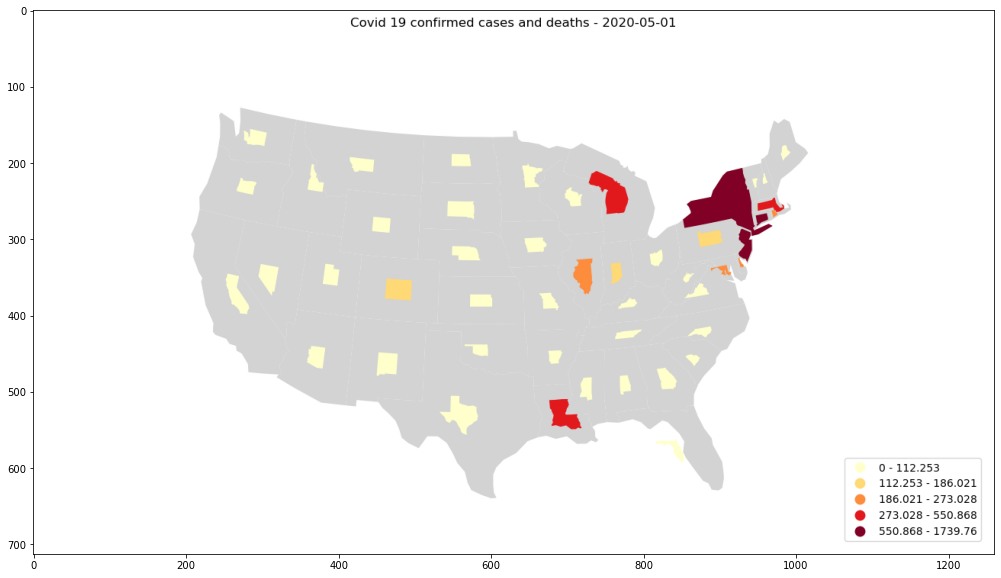

In [28]:
plt.figure(figsize = (20,10))
plt.imshow(mpimg.imread('data/noncontiguous/' + '20200501' + '.png')) 
plt.show()

In [25]:
# Generate ordered images
import os
os.system(r'''find data/noncontiguous/ -name '*.png' | xargs ls -rt | awk 'BEGIN{ a=0 }{ printf "cp %s data/noncontiguous/ordered/%04d.png\n", $0, a++ }' | bash''')

0

In [26]:
# Generate the time lapse video
os.system(r'''ffmpeg  -y -f image2 -r 1 -i data/noncontiguous/ordered/%4d.png -threads 8 -s:v 1920x1080 -vcodec libx264 -preset veryslow -qp 0 -map 0:0  movie_noncontiguous_1.mkv''')

0

# Contiguous cartogram univariate

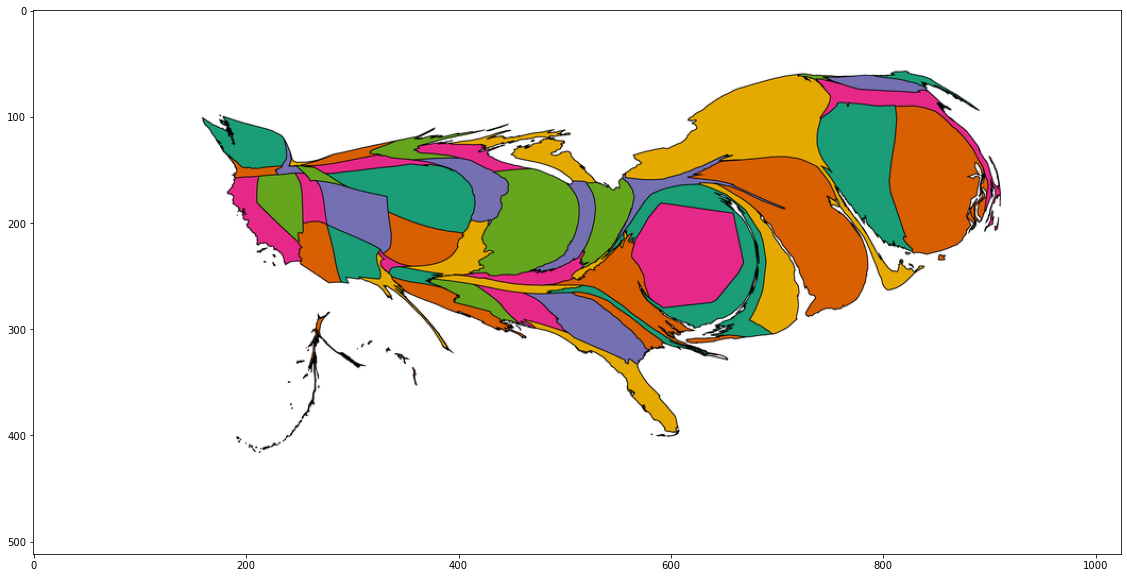

In [27]:
import os

from datetime import timedelta, date
from PIL import ImageColor
from PIL import Image

import math
import time

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import OrderedDict

cmaps = OrderedDict()
cmaps['Sequential'] = [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']


def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)


lo, hi = data_cases_cleaned['deaths_per_million'].min(), data_cases['deaths_per_million'].max()

def getColor(state):
    return [ x/256.0 for x in ImageColor.getcolor(data_color.loc[state].color, "RGB")]

start_date = date(2020, 6, 1)
end_date = date(2020, 6, 2)
for date in daterange(start_date, end_date):
    time.sleep(5)
    date = int(date.strftime("%Y%m%d"))
    #if date not in [20200122, 20200201, 20200305, 20200401, 20200501, 20200601, 20200701]: continue
    fname = 'data/csvs_colors/' + str(date) + '.csv'
    cases, base_cases = 0, 0.09 
    for state in states:
        state_abbrev = us_state_abbrev[state]
        if (date, state_abbrev) in data_cases_cleaned.index:
            base_cases = min(base_cases, data_cases_cleaned.loc[(date, state_abbrev)].current_cases_per_million)
    base_cases /= 100 
    fd = open(fname, 'w')
    for state in states:
        state_abbrev = us_state_abbrev[state]
        line = []
        line.append(int(data_maps_albers.loc[state].id))
        cases = base_cases
        deaths = 0
        if (date, state_abbrev) in data_cases_cleaned.index:
            cases += data_cases_cleaned.loc[(date, state_abbrev)].current_cases_per_million
            deaths += data_cases_cleaned.loc[(date, state_abbrev)].deaths_per_million
        else:
            pass
        line.append(cases)
        line.append(state)
        
        if cases == base_cases:
            line.extend([0.5, 0.5, 0.5])
        else:
            line.extend(getColor(state))
        fd.write(','.join(map(str, line))+'\n')
    fd.close()
    os.system('cartogram -eg data/albers_composite_us_states_processedmap.json -a ' + fname)
    

    bounds = (1024, 1024)
    pic = Image.open('cartogram.eps')
    pic.load(scale=10)

    if pic.mode in ('P', '1'):
        pic = pic.convert("RGB")

    ratio = min(bounds[0] / pic.size[0],
                bounds[1] / pic.size[1])
    new_size = (int(pic.size[0] * ratio), int(pic.size[1] * ratio))
    pic = pic.resize(new_size, Image.ANTIALIAS)

    # Save to PNG
    pic.save(fname.split('.')[0] + '.png')
    #https://stackoverflow.com/questions/45828514/how-to-convert-an-eps-file-into-a-png-in-python-3-6

plt.figure(figsize = (20,10))
plt.imshow(mpimg.imread(fname.split('.')[0] + '.png')) 
plt.show()

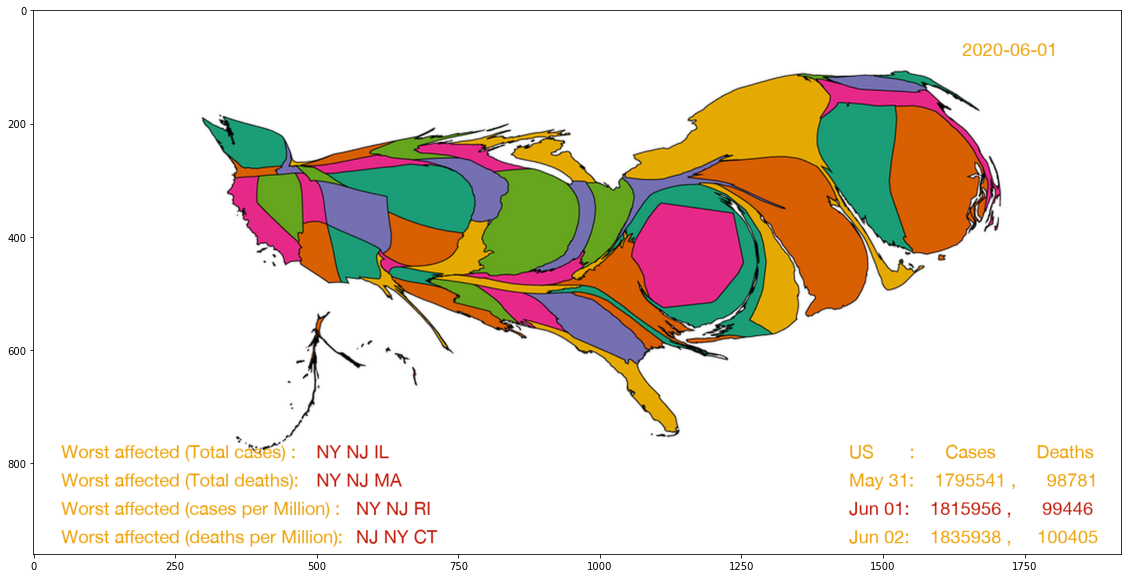

In [26]:
# Generate time series overlay on the image

from datetime import timedelta, date
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import os
import datetime
import calendar

months = {k: v for k,v in enumerate(calendar.month_abbr)}
months
 
font = ImageFont.truetype("/System/Library/Fonts/HelveticaNeue.ttc", 72)
fontsmall = ImageFont.truetype("/System/Library/Fonts/HelveticaNeue.ttc", 32)
fontcolor = (238,161,6)
fontcolorred = (194,24,7)

start_date = date(2020, 6, 1)
end_date = date(2020, 6, 2)
directory = 'data/csvs_colors/'
res_directory = directory + 'timed/' 
for date_var in daterange(start_date, end_date):
    date = date_var.strftime("%Y%m%d")
    #if date not in [20200401, 20200501, 20200601, 20200701]: continue
    fname = date + '.png'
    yest, today, tom = (date_var - datetime.timedelta(days=1)).strftime("%Y%m%d"), date_var.strftime("%Y%m%d"), (date_var + datetime.timedelta(days=1)).strftime("%Y%m%d")
    try:
        cases_states_yest = data_cases_cleaned.loc[(int(yest))]
    except:
        cases_states_yest, yest = data_cases_cleaned.loc[(int(today))], today
    
    cases_states_today = data_cases_cleaned.loc[(int(today))]
    
    try:
        cases_states_tom = data_cases_cleaned.loc[(int(tom))]
    except:
        cases_states_tom, tom = data_cases_cleaned.loc[(int(today))], today
        
    worst_cases = 'Worst affected (Total cases) : '
    worst_deaths ='Worst affected (Total deaths): '
    worst_cases_num =  ' '.join(cases_states_today.nlargest(3,'positive').index.tolist())
    worst_deaths_num =  ' '.join(cases_states_today.nlargest(3,'death').index.tolist())
    
    worst_cases_perM = 'Worst affected (cases per Million) : '
    worst_deaths_perM ='Worst affected (deaths per Million): '
    worst_cases_perM_num = ' '.join(cases_states_today.nlargest(3,'current_cases_per_million').index.tolist())
    worst_deaths_perM_num = ' '.join(cases_states_today.nlargest(3,'deaths_per_million').index.tolist())
    
    try:
        date_formatted = datetime.datetime.strptime(date, '%Y%m%d').strftime('%Y-%m-%d')
        widthtarget = 1920
        heighttarget = 1080
        img = Image.open(directory+fname)
        downSampleRatio = float(widthtarget) / float(img.width)
        imgDownSampled = img.resize( (widthtarget,round(img.height*downSampleRatio) ), resample=Image.LANCZOS)
       
        # Based on the script from https://www.amphioxus.org/content/timelapse-time-stamp-overlay
        draw = ImageDraw.Draw(imgDownSampled)
        
        draw.text((imgDownSampled.width-480,imgDownSampled.height-200), "US       : " + "Cases".center(15)  + "Deaths".center(12), fontcolor, font=fontsmall)
        draw.text((imgDownSampled.width-480,imgDownSampled.height-150), \
                  months[int(yest[4:6])] + " " + yest[6:] + ": " + \
                  format(int(cases_states_yest['positive'].sum()), "10d") + " , " + \
                  format(int(cases_states_yest['death'].sum()), "10d")
                  , fontcolor, font=fontsmall)
        draw.text((imgDownSampled.width-480,imgDownSampled.height-100), \
                  months[int(today[4:6])] + " " + today[6:] + ": " + \
                  format(int(cases_states_today['positive'].sum()), "10d") + " , " + \
                  format(int(cases_states_today['death'].sum()), "10d")
                  , fontcolorred, font=fontsmall)
        draw.text((imgDownSampled.width-480,imgDownSampled.height-50), \
                  months[int(tom[4:6])] + " " + tom[6:] + ": " + \
                  format(int(cases_states_tom['positive'].sum()), "10d") + " , " + \
                  format(int(cases_states_tom['death'].sum()), "10d")
                  , fontcolor, font=fontsmall)
        
        
        draw.text((imgDownSampled.width-280, 50), date_formatted, fontcolor, font=fontsmall)
        
        draw.text((50,imgDownSampled.height-200), worst_cases, fontcolor, font=fontsmall)
        draw.text((50,imgDownSampled.height-150), worst_deaths, fontcolor, font=fontsmall)
        draw.text((50,imgDownSampled.height-100), worst_cases_perM, fontcolor, font=fontsmall)
        draw.text((50,imgDownSampled.height-50), worst_deaths_perM, fontcolor, font=fontsmall)
        
        draw.text((50 + 450,imgDownSampled.height-200), worst_cases_num, fontcolorred, font=fontsmall)
        draw.text((50 + 450,imgDownSampled.height-150), worst_deaths_num, fontcolorred, font=fontsmall)
        draw.text((50 + 520,imgDownSampled.height-100), worst_cases_perM_num, fontcolorred, font=fontsmall)
        draw.text((50 + 520,imgDownSampled.height-50), worst_deaths_perM_num, fontcolorred, font=fontsmall)
        
        
        filename = res_directory + fname
        imgDownSampled.save(filename)
    except :
        print('Exception for : ', date)

plt.figure(figsize = (20,10))
plt.imshow(mpimg.imread(filename)) 
plt.show()


In [35]:
# Generate ordered images
os.system(r'''find data/csvs_colors/timed/ -name '*.png' | xargs ls -rt | awk 'BEGIN{ a=0 }{ printf "cp %s data/pngs_colors/%04d.png\n", $0, a++ }' | bash''')

0

In [36]:
# Generate the time lapse video
os.system(r'''ffmpeg  -y -f image2 -r 1 -i data/pngs_colors/%4d.png -threads 8 -s:v 1920x1080 -vcodec libx264 -preset veryslow -qp 0 -map 0:0  movie_colors_1.mkv''')

0

# Contiguous cartogram bivariate

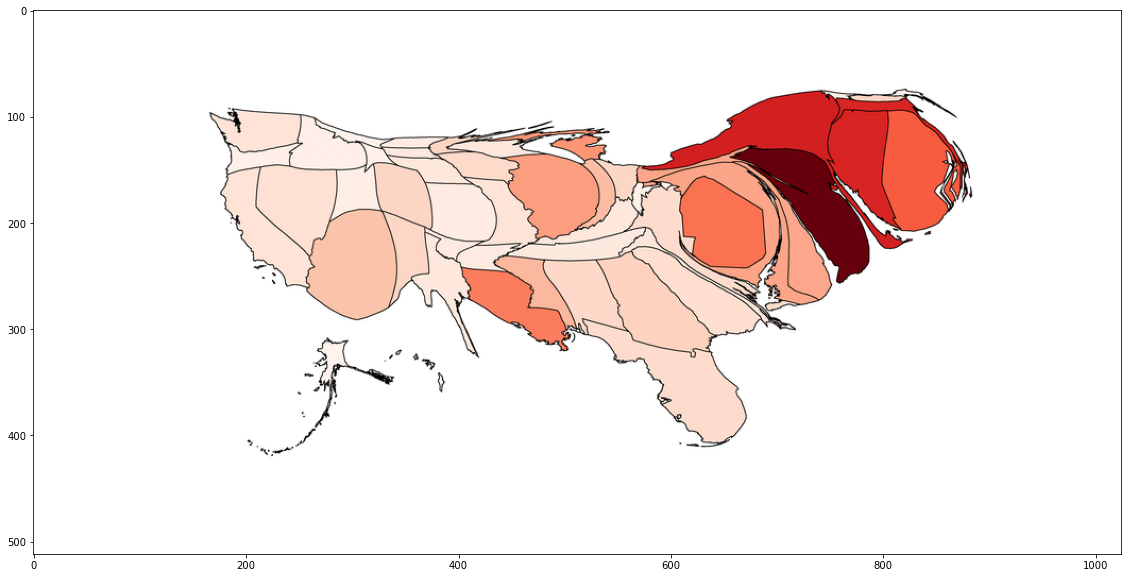

In [46]:
import os

from datetime import timedelta, date
from PIL import ImageColor
from PIL import Image

import math
import time

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import OrderedDict

cmaps = OrderedDict()
cmaps['Sequential'] = [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']


def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)


lo, hi = data_cases_cleaned['deaths_per_million'].min(), data_cases['deaths_per_million'].max()

def getColor(x, lo=lo, hi=hi):
    x = (x - lo) / (hi - lo)
    rgb = cm.get_cmap(cmaps['Sequential'][5])([x])[np.newaxis, :, :3]
    return rgb[0][0]

start_date = date(2020, 7, 20)
end_date = date(2020, 7, 21)
for date in daterange(start_date, end_date):
    time.sleep(15)
    date = int(date.strftime("%Y%m%d"))
    #if date not in [20200122, 20200201, 20200305, 20200401, 20200501, 20200601, 20200701]: continue
    fname = 'data/csvs_albers/' + str(date) + '.csv'
    cases, base_cases = 0, 0.09 
    for state in states:
        state_abbrev = us_state_abbrev[state]
        if (date, state_abbrev) in data_cases_cleaned.index:
            base_cases = min(base_cases, data_cases_cleaned.loc[(date, state_abbrev)].current_cases_per_million)
    base_cases /= 100 
    fd = open(fname, 'w')
    for state in states:
        state_abbrev = us_state_abbrev[state]
        line = []
        line.append(int(data_maps_albers.loc[state].id))
        cases = base_cases
        deaths = 0
        if (date, state_abbrev) in data_cases_cleaned.index:
            cases += data_cases_cleaned.loc[(date, state_abbrev)].current_cases_per_million
            deaths += data_cases_cleaned.loc[(date, state_abbrev)].deaths_per_million
        else:
            pass
        line.append(cases)
        line.append(state)
        
        if cases == base_cases:
            line.extend([0.5, 0.5, 0.5])
        else:
            line.extend(getColor(deaths))
        fd.write(','.join(map(str, line))+'\n')
    fd.close()
    os.system('cartogram -eg data/albers_composite_us_states_processedmap.json -a ' + fname)


    bounds = (1024, 1024)
    pic = Image.open('cartogram.eps')
    pic.load(scale=10)

    if pic.mode in ('P', '1'):
        pic = pic.convert("RGB")

    ratio = min(bounds[0] / pic.size[0],
                bounds[1] / pic.size[1])
    new_size = (int(pic.size[0] * ratio), int(pic.size[1] * ratio))
    pic = pic.resize(new_size, Image.ANTIALIAS)

    # Save to PNG
    pic.save(fname.split('.')[0] + '.png')
    #https://stackoverflow.com/questions/45828514/how-to-convert-an-eps-file-into-a-png-in-python-3-6

plt.figure(figsize = (20,10))
plt.imshow(mpimg.imread(fname.split('.')[0] + '.png')) 
plt.show()

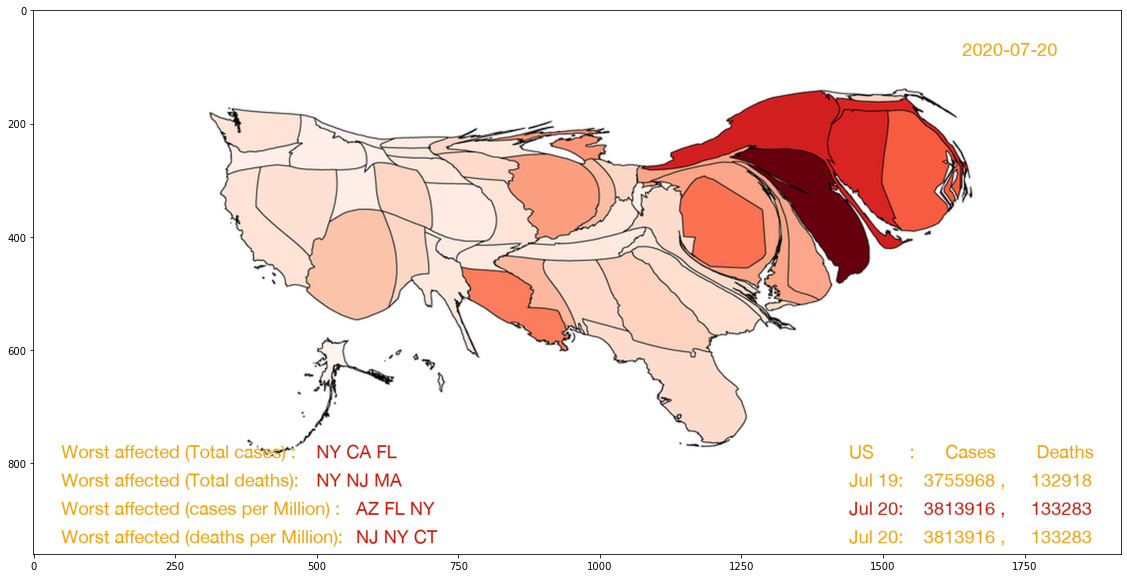

In [47]:
# Generate the time series overlay

from datetime import timedelta, date
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import os
import datetime
import calendar

months = {k: v for k,v in enumerate(calendar.month_abbr)}
months
 
font = ImageFont.truetype("/System/Library/Fonts/HelveticaNeue.ttc", 72)
fontsmall = ImageFont.truetype("/System/Library/Fonts/HelveticaNeue.ttc", 32)
fontcolor = (238,161,6)
fontcolorred = (194,24,7)

start_date = date(2020, 1, 22)
end_date = date(2020, 7, 21)
directory = 'data/csvs_albers/'
res_directory = directory + 'timed/' 
for date_var in daterange(start_date, end_date):
    date = date_var.strftime("%Y%m%d")
    #if date not in [20200401, 20200501, 20200601, 20200701]: continue
    fname = date + '.png'
    yest, today, tom = (date_var - datetime.timedelta(days=1)).strftime("%Y%m%d"), date_var.strftime("%Y%m%d"), (date_var + datetime.timedelta(days=1)).strftime("%Y%m%d")
    try:
        cases_states_yest = data_cases_cleaned.loc[(int(yest))]
    except:
        cases_states_yest, yest = data_cases_cleaned.loc[(int(today))], today
    
    cases_states_today = data_cases_cleaned.loc[(int(today))]
    
    try:
        cases_states_tom = data_cases_cleaned.loc[(int(tom))]
    except:
        cases_states_tom, tom = data_cases_cleaned.loc[(int(today))], today
        
    worst_cases = 'Worst affected (Total cases) : '
    worst_deaths ='Worst affected (Total deaths): '
    worst_cases_num =  ' '.join(cases_states_today.nlargest(3,'positive').index.tolist())
    worst_deaths_num =  ' '.join(cases_states_today.nlargest(3,'death').index.tolist())
    
    worst_cases_perM = 'Worst affected (cases per Million) : '
    worst_deaths_perM ='Worst affected (deaths per Million): '
    worst_cases_perM_num = ' '.join(cases_states_today.nlargest(3,'current_cases_per_million').index.tolist())
    worst_deaths_perM_num = ' '.join(cases_states_today.nlargest(3,'deaths_per_million').index.tolist())
    
    try:
        date_formatted = datetime.datetime.strptime(date, '%Y%m%d').strftime('%Y-%m-%d')
        widthtarget = 1920
        heighttarget = 1080
        img = Image.open(directory+fname)
        downSampleRatio = float(widthtarget) / float(img.width)
        imgDownSampled = img.resize( (widthtarget,round(img.height*downSampleRatio) ), resample=Image.LANCZOS)
 
        # Based on the script from https://www.amphioxus.org/content/timelapse-time-stamp-overlay
        draw = ImageDraw.Draw(imgDownSampled)
        
        draw.text((imgDownSampled.width-480,imgDownSampled.height-200), "US       : " + "Cases".center(15)  + "Deaths".center(12), fontcolor, font=fontsmall)
        draw.text((imgDownSampled.width-480,imgDownSampled.height-150), \
                  months[int(yest[4:6])] + " " + yest[6:] + ": " + \
                  format(int(cases_states_yest['positive'].sum()), "10d") + " , " + \
                  format(int(cases_states_yest['death'].sum()), "10d")
                  , fontcolor, font=fontsmall)
        draw.text((imgDownSampled.width-480,imgDownSampled.height-100), \
                  months[int(today[4:6])] + " " + today[6:] + ": " + \
                  format(int(cases_states_today['positive'].sum()), "10d") + " , " + \
                  format(int(cases_states_today['death'].sum()), "10d")
                  , fontcolorred, font=fontsmall)
        draw.text((imgDownSampled.width-480,imgDownSampled.height-50), \
                  months[int(tom[4:6])] + " " + tom[6:] + ": " + \
                  format(int(cases_states_tom['positive'].sum()), "10d") + " , " + \
                  format(int(cases_states_tom['death'].sum()), "10d")
                  , fontcolor, font=fontsmall)
        
        draw.text((imgDownSampled.width-280, 50), date_formatted, fontcolor, font=fontsmall)
        
        draw.text((50,imgDownSampled.height-200), worst_cases, fontcolor, font=fontsmall)
        draw.text((50,imgDownSampled.height-150), worst_deaths, fontcolor, font=fontsmall)
        draw.text((50,imgDownSampled.height-100), worst_cases_perM, fontcolor, font=fontsmall)
        draw.text((50,imgDownSampled.height-50), worst_deaths_perM, fontcolor, font=fontsmall)
        
        draw.text((50 + 450,imgDownSampled.height-200), worst_cases_num, fontcolorred, font=fontsmall)
        draw.text((50 + 450,imgDownSampled.height-150), worst_deaths_num, fontcolorred, font=fontsmall)
        draw.text((50 + 520,imgDownSampled.height-100), worst_cases_perM_num, fontcolorred, font=fontsmall)
        draw.text((50 + 520,imgDownSampled.height-50), worst_deaths_perM_num, fontcolorred, font=fontsmall)
        
        
        filename = res_directory + fname
        imgDownSampled.save(filename)
    except :
        print('Exception for : ', date)

plt.figure(figsize = (20,10))
plt.imshow(mpimg.imread(filename)) 
plt.show()

# Generate linear interpolation between frames (Needs different strategy, currently not used)

In [27]:
import json, sys, os, glob
#from interpimage import *
import os

pattern=res_directory + "*.png"
n = (end_date - start_date).days

noframes=n* 5


outdir="../"+res_directory + "out/"

filelist=glob.glob(pattern)
print(filelist)

ims=sorted([ f for f in filelist ], key=lambda x: os.path.getmtime(x))

data={
"filelist": [ {"name": "../"+f, "time": i+1} for i,f in enumerate(ims) ],
"inpattern": "../"+pattern,
"outdir": outdir,
"outformat": "png",
"noframes": noframes,
"gammas": [],
"blur": [],
"mask": [],
"ac":   [],
"rotate":0,
"nothreads":5,
"crop":  [[], [] ],
"scale": [  ]
}

with open(directory+'config.json', 'w') as outfile:
    json.dump(data, outfile)
print(json.dumps(data, indent=2, sort_keys=True))

'import json, sys, os, glob\n#from interpimage import *\nimport os\n\npattern=res_directory + "*.png"\nn = (end_date - start_date).days\n\nnoframes=n* 5\n\n\noutdir="../"+res_directory + "out/"\n\nfilelist=glob.glob(pattern)\nprint(filelist)\n\nims=sorted([ f for f in filelist ], key=lambda x: os.path.getmtime(x))\n\ndata={\n"filelist": [ {"name": "../"+f, "time": i+1} for i,f in enumerate(ims) ],\n"inpattern": "../"+pattern,\n"outdir": outdir,\n"outformat": "png",\n"noframes": noframes,\n"gammas": [],\n"blur": [],\n"mask": [],\n"ac":   [],\n"rotate":0,\n"nothreads":5,\n"crop":  [[], [] ],\n"scale": [  ]\n}\n\nwith open(directory+\'config.json\', \'w\') as outfile:\n    json.dump(data, outfile)\nprint(json.dumps(data, indent=2, sort_keys=True))\n'

In [102]:
# Generate ordered images
os.system(r'''find data/csvs_albers/timed/ -name '*.png' | xargs ls -rt | awk 'BEGIN{ a=0 }{ printf "cp %s data/pngs_albers/%04d.png\n", $0, a++ }' | bash''')

0

In [103]:
# Generate the time lapse video
os.system(r'''ffmpeg  -y -f image2 -r 1 -i data/pngs_albers/%4d.png -threads 8 -s:v 1920x1080 -vcodec libx264 -preset veryslow -qp 0 -map 0:0  movie_albers_12.mkv''')

0

In [45]:
# Generate the time lapse video
os.system(r'''ffmpeg  -y -f image2 -r 1.5 -i data/noncontiguous/ordered/%4d.png -threads 8 -s:v 1920x1080 -vcodec libx264 -preset veryslow -qp 0 -map 0:0  movie_noncontig_2.mkv''')

0